In [ ]:
#This Notebook will show training Mobinenetv3-small on Pytorch Summary of the notebook

#Training has THREE parts Optimization of Hyperparameters using Sequential Model Based Optimization (SMBO). 
#Fitting the Model with the best hyperparameters obtained from optimization. 
#Testing the Model on test set For optimization: Trained with 15 epochs and patient of 3. 
#Total of 300 trials for looking of best hyperparameters combination. 
#For fitting the Model with best hyperparameters: Trained with 100 epochs and patient of 10.

# 1. Importing the Libraries

In [1]:
import os
import torch
import time
import random
import hyperopt
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from hyperopt.pyll.stochastic import sample
from torch.utils.data import DataLoader
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from torch.optim import Adam, SGD, RMSprop
from torchvision.models import mobilenet_v3_small
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Checking Training machine
!nvidia-smi

Sat Feb  3 13:22:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        On  | 00000000:07:00.0 Off |                  N/A |
|  0%   54C    P8              17W / 170W |      2MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Initializing the model

#3. Loading images and Transform

In [ ]:
!unzip '/home/g6501222802/thesis/data/opt_data.zip' -d "/home/g6501222802/thesis"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Data/train/HEALTHY/Image_1907.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1909.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1910.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1913.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1915.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1916.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1919.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1921.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1925.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1927.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1929.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1930.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1931.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1932.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1934.jpg  
  inflating: /content/Data/train/HEALTHY/Image_1935.jpg  
  inflating: /content

In [9]:
def get_data_loader(batch_size):
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

    train_dataset = ImageFolder(root='/home/g6501222802/thesis/opt_data/train', transform=train_transform)
    val_dataset = ImageFolder(root='/home/g6501222802/thesis/opt_data/val', transform=val_transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

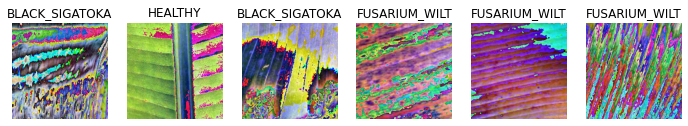

In [9]:
# Print some random images from the dataset
train_transform = transforms.Compose([    # Define data transformations including data augmentation
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
train_dataset = datasets.ImageFolder('/home/g6501222802/thesis/opt_data/train', transform=train_transform)
sample_indices = random.sample(range(len(train_dataset)), 6)
sample_images, sample_labels = zip(*[train_dataset[i] for i in sample_indices])
sample_images = [transforms.functional.to_pil_image(img) for img in sample_images]
sample_labels = [train_dataset.classes[label] for label in sample_labels]

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(np.array(sample_images[i]))
    plt.title(sample_labels[i])
    plt.axis('off')
plt.show()

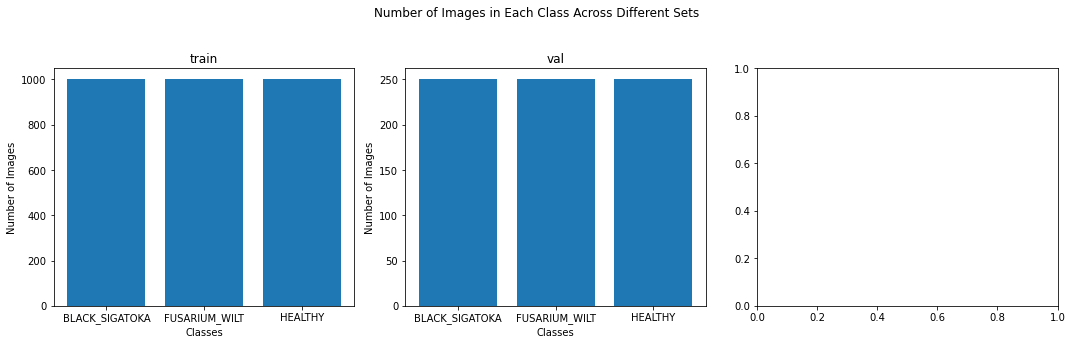

In [10]:
def count_images_in_directory(directory):
    return len([file for file in os.listdir(directory) if file.endswith('.jpg')])

# Main directory path
main_directory_path = '/home/g6501222802/thesis/opt_data'

# Sub-directories
sets = ['train', 'val']
classes = ['BLACK_SIGATOKA', 'FUSARIUM_WILT', 'HEALTHY']

# Dictionary to hold image counts
image_counts = {set_name: {class_name: 0 for class_name in classes} for set_name in sets}

# Counting images in each set and class
for set_name in sets:
    for class_name in classes:
        dir_path = os.path.join(main_directory_path, set_name, class_name)
        image_counts[set_name][class_name] = count_images_in_directory(dir_path)

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Number of Images in Each Class Across Different Sets')

for i, set_name in enumerate(sets):
    counts = [image_counts[set_name][class_name] for class_name in classes]
    axs[i].bar(classes, counts)
    axs[i].set_title(set_name)
    axs[i].set_xlabel('Classes')
    axs[i].set_ylabel('Number of Images')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 4. Optimizing Mobilenetv3-smal Hyperparameters with Siquential Model Based optimization(SMBO)

Define early Stopping

In [10]:
# Define call back for early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0,path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [15]:
def reset_globals():  #Declaring global varibales for storing loss and accuracy during training

    global train_losses, train_accuracies, val_losses, val_accuracies
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

reset_globals()

def objective(params):  #Objective function for training model with hyperparameters tuning

    global train_losses, train_accuracies, val_losses, val_accuracies, iteration
    early_stopping = EarlyStopping(patience=5, verbose=True)  #Early stopping

    iteration += 1 # For Tracking iterations

    start_time = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Checking for Cuda
    train_loader, val_loader = get_data_loader(params['batch_size']) #data Loader
    
    #Initializing the Model
    model = models.mobilenet_v3_small(pretrained=True)  #define mobilenetv3-small pre-trained model
    # Modify the classifier to match the number of classes in your dataset
    num_classes = len(train_loader.dataset.classes)  # Assuming you have defined train_loader
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    model = model.to(device)      # Move to cuda if available

    criterion = nn.CrossEntropyLoss()

    # Optimizer selection
    if params['optimizer'] == 'Adam':
        optimizer = Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'SGD':
        optimizer = SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])
    else:
        optimizer = RMSprop(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])


    epoch_data = [] #Storing number of epochs

    for epoch in range(15): #Training loop

        model.train()
        train_loss =0.0
        train_correct= 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * train_correct / total
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_accuracy)

        model.eval()  #Validation loop
        val_loss =0.0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_accuracy = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Acc: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}')
        epoch_data.append([epoch+1, train_accuracy, train_loss, val_accuracy, val_loss])

         # Check for early stopping
        early_stopping(val_losses[-1], model)
        if early_stopping.early_stop:
          print("Early stopping")
          break
            

    end_time = time.time()
    iteration_duration = end_time - start_time


    return {      #Dictionary to return optimization results and other parameters
        'loss': val_loss,
        'status': STATUS_OK,
        'val_accuracy': val_accuracy,
        'train_accuracy': train_accuracy,
        'train_loss': train_loss,
        'iteration_time': iteration_duration,
        'iterations': iteration,
        'params': params
    }

optimizer_choices = {Adam: 'Adam', SGD: 'SGD', RMSprop: 'RMSprop'}

# call for global variable to count interations
global  iteration

iteration = 0 # Starting count from 0

space = {    #Setting hyperparameters space
    #'lr': hp.uniform('lr', 0.00001, 0.9),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.005)),
    'momentum': hp.uniform('momentum', 0.9, 0.99),
    'batch_size': hp.choice('batch_size', [64, 128, 256]),
    'optimizer': hp.choice('optimizer', [Adam, SGD, RMSprop]),
}

#Run Optimization with 300 trials
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=300, trials=trials)

# Extracting trial data and saving to CSV
results = []
for trial in trials.trials:
    result = trial['result']
    result['params']['optimizer'] = optimizer_choices[result['params']['optimizer']]
    results.append(result)

df = pd.DataFrame(results)
df.to_csv('/home/g6501222802/thesis/results/mobilenetv3-small_s1_results.csv', index=False) #Save the results to specified file
print("Best parameters found:", best)

Epoch 1: Train Acc: 72.10%, Train Loss: 30.7967, Val Acc: 33.60%, Val Loss: 43.9268                           
Validation loss decreased (inf --> 3.660567). Saving model...                                                 
Epoch 2: Train Acc: 86.37%, Train Loss: 16.9786, Val Acc: 87.20%, Val Loss: 4.3132                            
Validation loss decreased (3.660567 --> 0.359433). Saving model...                                            
Epoch 3: Train Acc: 89.37%, Train Loss: 13.6053, Val Acc: 89.60%, Val Loss: 3.3281                            
Validation loss decreased (0.359433 --> 0.277345). Saving model...                                            
Epoch 4: Train Acc: 92.93%, Train Loss: 9.0829, Val Acc: 88.93%, Val Loss: 3.4543                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 93.83%, Train Loss: 8.1276, Val Acc: 89.20%, Val Loss: 3.5094                             
E

Validation loss decreased (0.334847 --> 0.255555). Saving model...                                            
Epoch 11: Train Acc: 94.07%, Train Loss: 4.2818, Val Acc: 90.13%, Val Loss: 2.2291                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 12: Train Acc: 93.40%, Train Loss: 5.5315, Val Acc: 92.93%, Val Loss: 1.5027                            
Validation loss decreased (0.255555 --> 0.250443). Saving model...                                            
Epoch 13: Train Acc: 91.77%, Train Loss: 6.6288, Val Acc: 89.47%, Val Loss: 1.8271                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 14: Train Acc: 92.43%, Train Loss: 4.9510, Val Acc: 90.00%, Val Loss: 1.8656                            
EarlyStopping counter: 2 out of 5                                                                             
E

Epoch 12: Train Acc: 96.37%, Train Loss: 2.4321, Val Acc: 93.33%, Val Loss: 1.3686                            
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 69.07%, Train Loss: 33.9535, Val Acc: 36.00%, Val Loss: 27.7608                           
Validation loss decreased (inf --> 2.313402). Saving model...                                                 
Epoch 2: Train Acc: 81.93%, Train Loss: 22.1797, Val Acc: 86.00%, Val Loss: 4.6419                            
Validation loss decreased (2.313402 --> 0.386824). Saving model...                                            
Epoch 4: Train Acc: 88.60%, Train Loss: 14.3578, Val Acc: 79.73%, Val Loss: 5.6420                            
EarlyStopping counter: 1 out of 5                                                                             
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 1: Train Acc: 32.60%, Train Loss: 851.6573, Val Acc: 33.33%, Val Loss: 72.3013                          
Validation loss decreased (inf --> 12.050210). Saving model...                                                
Epoch 2: Train Acc: 34.60%, Train Loss: 1358.5843, Val Acc: 33.33%, Val Loss: 351.1690                        
EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 32.10%, Train Loss: 866.1938, Val Acc: 33.33%, Val Loss: 33.0245                          
Validation loss decreased (12.050210 --> 5.504089). Saving model...                                           
Epoch 4: Train Acc: 33.47%, Train Loss: 109.7486, Val Acc: 33.33%, Val Loss: 22.9963                          
Validation loss decreased (5.504089 --> 3.832716). Saving model...                                            
E

Epoch 8: Train Acc: 91.50%, Train Loss: 2.8979, Val Acc: 86.93%, Val Loss: 1.0125                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 91.27%, Train Loss: 2.6481, Val Acc: 89.47%, Val Loss: 0.7996                             
Validation loss decreased (0.336229 --> 0.266522). Saving model...                                            
Epoch 10: Train Acc: 92.87%, Train Loss: 2.3673, Val Acc: 90.80%, Val Loss: 0.7160                            
Validation loss decreased (0.266522 --> 0.238664). Saving model...                                            
Epoch 11: Train Acc: 93.10%, Train Loss: 2.1947, Val Acc: 91.47%, Val Loss: 0.7003                            
Validation loss decreased (0.238664 --> 0.233437). Saving model...                                            
Epoch 12: Train Acc: 94.03%, Train Loss: 1.8324, Val Acc: 90.93%, Val Loss: 0.7548                            
E

Validation loss decreased (1.083016 --> 1.056627). Saving model...                                            
Epoch 14: Train Acc: 47.43%, Train Loss: 11.9499, Val Acc: 41.60%, Val Loss: 3.1554                           
Validation loss decreased (1.056627 --> 1.051791). Saving model...                                            
Epoch 15: Train Acc: 61.83%, Train Loss: 10.3488, Val Acc: 62.93%, Val Loss: 2.4376                           
Validation loss decreased (1.051791 --> 0.812526). Saving model...                                            
Epoch 1: Train Acc: 54.67%, Train Loss: 11.1290, Val Acc: 33.33%, Val Loss: 3.4764                            
Validation loss decreased (inf --> 1.158808). Saving model...                                                 
Epoch 2: Train Acc: 76.17%, Train Loss: 7.6265, Val Acc: 33.33%, Val Loss: 5.2840                             
EarlyStopping counter: 1 out of 5                                                                             
E

Epoch 12: Train Acc: 97.23%, Train Loss: 1.0426, Val Acc: 93.60%, Val Loss: 0.6711                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 13: Train Acc: 97.33%, Train Loss: 0.8725, Val Acc: 93.60%, Val Loss: 0.7385                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 14: Train Acc: 98.07%, Train Loss: 0.7301, Val Acc: 92.27%, Val Loss: 0.7210                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 15: Train Acc: 98.10%, Train Loss: 0.5958, Val Acc: 92.53%, Val Loss: 0.8409                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 1: Train Acc: 59.90%, Train Loss: 9.9726, Val Acc: 33.33%, Val Loss: 3.8182                             
V

Epoch 5: Train Acc: 91.27%, Train Loss: 11.2752, Val Acc: 90.27%, Val Loss: 3.4398                            
Validation loss decreased (0.338802 --> 0.286648). Saving model...                                            
Epoch 6: Train Acc: 94.00%, Train Loss: 8.4908, Val Acc: 91.20%, Val Loss: 3.4891                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 94.27%, Train Loss: 7.7852, Val Acc: 92.40%, Val Loss: 2.6203                             
Validation loss decreased (0.286648 --> 0.218362). Saving model...                                            
Epoch 8: Train Acc: 94.07%, Train Loss: 7.8958, Val Acc: 91.47%, Val Loss: 3.1467                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 94.47%, Train Loss: 7.1319, Val Acc: 91.73%, Val Loss: 3.1088                             
E

Validation loss decreased (0.529996 --> 0.456377). Saving model...                                            
Epoch 6: Train Acc: 88.87%, Train Loss: 6.9060, Val Acc: 86.40%, Val Loss: 2.0671                             
Validation loss decreased (0.456377 --> 0.344525). Saving model...                                            
Epoch 7: Train Acc: 90.93%, Train Loss: 6.1247, Val Acc: 86.13%, Val Loss: 2.6988                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 8: Train Acc: 91.33%, Train Loss: 5.2337, Val Acc: 87.33%, Val Loss: 1.9567                             
Validation loss decreased (0.344525 --> 0.326111). Saving model...                                            
Epoch 9: Train Acc: 93.53%, Train Loss: 4.1283, Val Acc: 89.60%, Val Loss: 1.8681                             
Validation loss decreased (0.326111 --> 0.311356). Saving model...                                            
E

Epoch 4: Train Acc: 89.93%, Train Loss: 12.5171, Val Acc: 86.00%, Val Loss: 4.3739                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 90.43%, Train Loss: 11.8553, Val Acc: 86.67%, Val Loss: 4.1834                            
Validation loss decreased (0.358258 --> 0.348616). Saving model...                                            
Epoch 6: Train Acc: 92.03%, Train Loss: 10.2121, Val Acc: 89.20%, Val Loss: 3.8747                            
Validation loss decreased (0.348616 --> 0.322892). Saving model...                                            
Epoch 7: Train Acc: 92.97%, Train Loss: 9.2073, Val Acc: 89.33%, Val Loss: 3.8037                             
Validation loss decreased (0.322892 --> 0.316974). Saving model...                                            
Epoch 8: Train Acc: 93.97%, Train Loss: 7.7770, Val Acc: 89.33%, Val Loss: 3.6024                             
V

Epoch 4: Train Acc: 85.97%, Train Loss: 9.3138, Val Acc: 85.33%, Val Loss: 2.1576                             
Validation loss decreased (0.550360 --> 0.359601). Saving model...                                            
Epoch 5: Train Acc: 88.43%, Train Loss: 7.7040, Val Acc: 84.27%, Val Loss: 2.6758                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 6: Train Acc: 90.13%, Train Loss: 6.9564, Val Acc: 89.87%, Val Loss: 2.0447                             
Validation loss decreased (0.359601 --> 0.340786). Saving model...                                            
Epoch 7: Train Acc: 89.77%, Train Loss: 6.8588, Val Acc: 85.20%, Val Loss: 2.5235                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 8: Train Acc: 90.63%, Train Loss: 5.9725, Val Acc: 86.53%, Val Loss: 2.1194                             
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 11: Train Acc: 95.73%, Train Loss: 2.7544, Val Acc: 92.67%, Val Loss: 1.3442                            
Validation loss decreased (0.255658 --> 0.224035). Saving model...                                            
Epoch 12: Train Acc: 95.93%, Train Loss: 2.6318, Val Acc: 88.13%, Val Loss: 2.7605                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 13: Train Acc: 97.23%, Train Loss: 2.1973, Val Acc: 94.00%, Val Loss: 1.2617                            
Validation loss decreased (0.224035 --> 0.210278). Saving model...                                            
Epoch 14: Train Acc: 97.93%, Train Loss: 1.5598, Val Acc: 91.87%, Val Loss: 1.5965                            
EarlyStopping counter: 1 out of 5                                                                             
E

Validation loss decreased (0.309367 --> 0.243309). Saving model...                                            
Epoch 9: Train Acc: 95.60%, Train Loss: 1.4798, Val Acc: 91.07%, Val Loss: 0.8414                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 96.67%, Train Loss: 1.1607, Val Acc: 91.87%, Val Loss: 0.7513                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 11: Train Acc: 97.50%, Train Loss: 0.8355, Val Acc: 92.53%, Val Loss: 0.7557                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 12: Train Acc: 97.87%, Train Loss: 0.7298, Val Acc: 87.33%, Val Loss: 1.2907                            
EarlyStopping counter: 4 out of 5                                                                             
E

Epoch 11: Train Acc: 90.07%, Train Loss: 3.3773, Val Acc: 88.00%, Val Loss: 0.9621                            
Validation loss decreased (0.391682 --> 0.320691). Saving model...                                            
Epoch 12: Train Acc: 90.67%, Train Loss: 3.0613, Val Acc: 88.53%, Val Loss: 0.8674                            
Validation loss decreased (0.320691 --> 0.289127). Saving model...                                            
Epoch 13: Train Acc: 90.67%, Train Loss: 2.9393, Val Acc: 87.33%, Val Loss: 0.8672                            
Validation loss decreased (0.289127 --> 0.289067). Saving model...                                            
Epoch 14: Train Acc: 91.17%, Train Loss: 2.8452, Val Acc: 90.53%, Val Loss: 0.7143                            
Validation loss decreased (0.289067 --> 0.238089). Saving model...                                            
Epoch 15: Train Acc: 92.37%, Train Loss: 2.5026, Val Acc: 88.13%, Val Loss: 0.9398                            
E

EarlyStopping counter: 3 out of 5                                                                             
Epoch 12: Train Acc: 93.43%, Train Loss: 2.2962, Val Acc: 92.53%, Val Loss: 0.6063                            
Validation loss decreased (0.306440 --> 0.202097). Saving model...                                            
Epoch 13: Train Acc: 95.40%, Train Loss: 1.6766, Val Acc: 93.73%, Val Loss: 0.5756                            
Validation loss decreased (0.202097 --> 0.191863). Saving model...                                            
Epoch 14: Train Acc: 95.10%, Train Loss: 1.5480, Val Acc: 93.60%, Val Loss: 0.5693                            
Validation loss decreased (0.191863 --> 0.189763). Saving model...                                            
Epoch 15: Train Acc: 95.63%, Train Loss: 1.4052, Val Acc: 93.73%, Val Loss: 0.4720                            
Validation loss decreased (0.189763 --> 0.157323). Saving model...                                            
E

EarlyStopping counter: 2 out of 5                                                                             
Epoch 12: Train Acc: 33.20%, Train Loss: 420.9207, Val Acc: 33.33%, Val Loss: 84.1634                         
Validation loss decreased (10.890553 --> 7.013620). Saving model...                                           
Epoch 13: Train Acc: 34.13%, Train Loss: 2051.0042, Val Acc: 33.33%, Val Loss: 1915.1956                      
EarlyStopping counter: 1 out of 5                                                                             
Epoch 14: Train Acc: 34.87%, Train Loss: 4322.4553, Val Acc: 33.33%, Val Loss: 593.9529                       
EarlyStopping counter: 2 out of 5                                                                             
Epoch 15: Train Acc: 34.10%, Train Loss: 2237.9907, Val Acc: 33.33%, Val Loss: 193.2834                       
EarlyStopping counter: 3 out of 5                                                                             
E

EarlyStopping counter: 3 out of 5                                                                             
Epoch 11: Train Acc: 34.30%, Train Loss: 55.3670, Val Acc: 33.33%, Val Loss: 41.3738                          
EarlyStopping counter: 4 out of 5                                                                             
Epoch 12: Train Acc: 33.20%, Train Loss: 62.9931, Val Acc: 33.33%, Val Loss: 15.4986                          
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 40.80%, Train Loss: 21.5656, Val Acc: 33.33%, Val Loss: 11.8269                           
Validation loss decreased (inf --> 3.942315). Saving model...                                                 
Epoch 2: Train Acc: 50.10%, Train Loss: 11.6814, Val Acc: 33.33%, Val Loss: 3.7129                            
V

Validation loss decreased (0.260131 --> 0.190249). Saving model...                                            
Epoch 13: Train Acc: 96.90%, Train Loss: 0.9749, Val Acc: 93.47%, Val Loss: 0.6371                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 14: Train Acc: 98.40%, Train Loss: 0.5508, Val Acc: 92.27%, Val Loss: 1.2590                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 15: Train Acc: 98.00%, Train Loss: 0.7008, Val Acc: 93.07%, Val Loss: 1.0782                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 1: Train Acc: 71.60%, Train Loss: 33.4810, Val Acc: 62.13%, Val Loss: 13.4658                           
Validation loss decreased (inf --> 1.122150). Saving model...                                                 
E

EarlyStopping counter: 2 out of 5                                                                             
Epoch 11: Train Acc: 97.03%, Train Loss: 0.9902, Val Acc: 90.67%, Val Loss: 0.8962                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 12: Train Acc: 97.17%, Train Loss: 0.8209, Val Acc: 89.60%, Val Loss: 0.9598                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 13: Train Acc: 98.27%, Train Loss: 0.6622, Val Acc: 90.53%, Val Loss: 1.1028                            
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 66.33%, Train Loss: 37.0395, Val Acc: 44.27%, Val Loss: 29.6201                           
V

Validation loss decreased (1.325566 --> 1.117590). Saving model...                                            
Epoch 5: Train Acc: 86.17%, Train Loss: 4.3564, Val Acc: 74.00%, Val Loss: 2.1390                             
Validation loss decreased (1.117590 --> 0.713015). Saving model...                                            
Epoch 6: Train Acc: 87.10%, Train Loss: 3.8949, Val Acc: 71.47%, Val Loss: 2.1020                             
Validation loss decreased (0.713015 --> 0.700681). Saving model...                                            
Epoch 7: Train Acc: 88.97%, Train Loss: 3.5124, Val Acc: 85.07%, Val Loss: 1.4554                             
Validation loss decreased (0.700681 --> 0.485135). Saving model...                                            
Epoch 8: Train Acc: 91.37%, Train Loss: 2.7731, Val Acc: 84.67%, Val Loss: 1.2526                             
Validation loss decreased (0.485135 --> 0.417521). Saving model...                                            
E

EarlyStopping counter: 3 out of 5                                                                             
Epoch 13: Train Acc: 96.13%, Train Loss: 1.1070, Val Acc: 91.47%, Val Loss: 0.8418                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 14: Train Acc: 95.93%, Train Loss: 1.3208, Val Acc: 92.00%, Val Loss: 0.8096                            
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 47.17%, Train Loss: 15.4753, Val Acc: 33.33%, Val Loss: 3.4503                            
Validation loss decreased (inf --> 1.150111). Saving model...                                                 
Epoch 2: Train Acc: 63.00%, Train Loss: 11.5552, Val Acc: 34.53%, Val Loss: 6.0256                            
E

Epoch 7: Train Acc: 91.83%, Train Loss: 2.7068, Val Acc: 85.87%, Val Loss: 1.2010                             
Validation loss decreased (0.502683 --> 0.400329). Saving model...                                            
Epoch 8: Train Acc: 92.70%, Train Loss: 2.4249, Val Acc: 88.93%, Val Loss: 1.1781                             
Validation loss decreased (0.400329 --> 0.392688). Saving model...                                            
Epoch 9: Train Acc: 93.80%, Train Loss: 2.1854, Val Acc: 81.47%, Val Loss: 1.6499                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 93.47%, Train Loss: 2.0233, Val Acc: 91.73%, Val Loss: 0.7044                            
Validation loss decreased (0.392688 --> 0.234808). Saving model...                                            
Epoch 11: Train Acc: 94.63%, Train Loss: 1.8065, Val Acc: 90.40%, Val Loss: 0.9885                            
E

Epoch 2: Train Acc: 44.37%, Train Loss: 428.8294, Val Acc: 33.33%, Val Loss: 648775.1890                      
EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 51.93%, Train Loss: 582.3061, Val Acc: 46.93%, Val Loss: 355606.7129                      
EarlyStopping counter: 2 out of 5                                                                             
Epoch 4: Train Acc: 54.63%, Train Loss: 599.2788, Val Acc: 55.60%, Val Loss: 113009.3242                      
EarlyStopping counter: 3 out of 5                                                                             
Epoch 5: Train Acc: 58.70%, Train Loss: 653.3187, Val Acc: 51.73%, Val Loss: 110829.0684                      
EarlyStopping counter: 4 out of 5                                                                             
Epoch 6: Train Acc: 55.93%, Train Loss: 984.0827, Val Acc: 52.40%, Val Loss: 98205.5786                       
E

Epoch 13: Train Acc: 90.97%, Train Loss: 6.9615, Val Acc: 90.00%, Val Loss: 1.8743                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 14: Train Acc: 89.53%, Train Loss: 7.1654, Val Acc: 89.87%, Val Loss: 2.3020                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 15: Train Acc: 90.57%, Train Loss: 7.8937, Val Acc: 87.47%, Val Loss: 2.6688                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 1: Train Acc: 56.83%, Train Loss: 11.4152, Val Acc: 33.33%, Val Loss: 4.5381                            
Validation loss decreased (inf --> 1.512700). Saving model...                                                 
Epoch 2: Train Acc: 72.90%, Train Loss: 8.1347, Val Acc: 33.33%, Val Loss: 5.7928                             
E

Epoch 15: Train Acc: 97.50%, Train Loss: 0.9225, Val Acc: 92.80%, Val Loss: 0.7129                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 1: Train Acc: 49.10%, Train Loss: 41.9495, Val Acc: 33.33%, Val Loss: 71.4484                           
Validation loss decreased (inf --> 11.908073). Saving model...                                                
Epoch 2: Train Acc: 52.53%, Train Loss: 97.9090, Val Acc: 34.27%, Val Loss: 751.7827                          
EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 50.87%, Train Loss: 72.9266, Val Acc: 24.13%, Val Loss: 52.7975                           
Validation loss decreased (11.908073 --> 8.799586). Saving model...                                           
Epoch 4: Train Acc: 48.50%, Train Loss: 92.2202, Val Acc: 24.80%, Val Loss: 35.1947                           
V

EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 33.50%, Train Loss: 673.5790, Val Acc: 33.33%, Val Loss: 52.2019                          
Validation loss decreased (inf --> 8.700309). Saving model...                                                 
Epoch 2: Train Acc: 31.67%, Train Loss: 1529.3562, Val Acc: 33.33%, Val Loss: 556.3870                        
EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 31.43%, Train Loss: 2680.4708, Val Acc: 33.33%, Val Loss: 476.3932                        
EarlyStopping counter: 2 out of 5                                                                             
Epoch 4: Train Acc: 32.13%, Train Loss: 2171.1403, Val Acc: 33.33%, Val Loss: 1018.6747                       
E

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 8: Train Acc: 90.80%, Train Loss: 5.5056, Val Acc: 91.20%, Val Loss: 1.4098                             
Validation loss decreased (0.287435 --> 0.234967). Saving model...                                            
Epoch 9: Train Acc: 92.57%, Train Loss: 4.7809, Val Acc: 90.93%, Val Loss: 1.4994                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 93.27%, Train Loss: 4.3778, Val Acc: 93.73%, Val Loss: 1.1862                            
Validation loss decreased (0.234967 --> 0.197703). Saving model...                                            
Epoch 11: Train Acc: 94.43%, Train Loss: 3.6666, Val Acc: 92.27%, Val Loss: 1.1984                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 12: Train Acc: 94.60%, Train Loss: 3.5442, Val Acc: 91.73%, Val Loss: 1.4609                            
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 86.73%, Train Loss: 4.3657, Val Acc: 62.27%, Val Loss: 9.2328                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 6: Train Acc: 89.13%, Train Loss: 3.6254, Val Acc: 82.27%, Val Loss: 2.1814                             
Validation loss decreased (0.806278 --> 0.727133). Saving model...                                            
Epoch 7: Train Acc: 90.77%, Train Loss: 3.1862, Val Acc: 66.13%, Val Loss: 3.7336                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 8: Train Acc: 92.57%, Train Loss: 2.4393, Val Acc: 76.80%, Val Loss: 3.0563                             
EarlyStopping counter: 2 out of 5                                                                             
E

EarlyStopping counter: 2 out of 5                                                                             
Epoch 4: Train Acc: 33.10%, Train Loss: 131.7210, Val Acc: 33.33%, Val Loss: 39.6424                          
EarlyStopping counter: 3 out of 5                                                                             
Epoch 5: Train Acc: 33.60%, Train Loss: 89.2878, Val Acc: 33.33%, Val Loss: 27.5611                           
Validation loss decreased (10.989553 --> 9.187049). Saving model...                                           
Epoch 6: Train Acc: 33.17%, Train Loss: 62.2647, Val Acc: 33.33%, Val Loss: 14.9687                           
Validation loss decreased (9.187049 --> 4.989568). Saving model...                                            
Epoch 7: Train Acc: 32.70%, Train Loss: 41.1149, Val Acc: 33.33%, Val Loss: 10.0712                           
Validation loss decreased (4.989568 --> 3.357058). Saving model...                                            
E

Epoch 9: Train Acc: 87.27%, Train Loss: 5.8620, Val Acc: 85.73%, Val Loss: 1.3082                             
Validation loss decreased (0.797482 --> 0.436050). Saving model...                                            
Epoch 10: Train Acc: 87.33%, Train Loss: 4.2945, Val Acc: 74.40%, Val Loss: 2.5502                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 11: Train Acc: 89.13%, Train Loss: 4.4311, Val Acc: 83.47%, Val Loss: 1.6940                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 12: Train Acc: 90.33%, Train Loss: 4.0020, Val Acc: 79.07%, Val Loss: 1.9879                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 13: Train Acc: 88.80%, Train Loss: 4.4924, Val Acc: 86.93%, Val Loss: 1.5049                            
E

Epoch 6: Train Acc: 89.23%, Train Loss: 7.2224, Val Acc: 86.67%, Val Loss: 2.0444                             
Validation loss decreased (0.394080 --> 0.340736). Saving model...                                            
Epoch 7: Train Acc: 90.80%, Train Loss: 6.2818, Val Acc: 89.73%, Val Loss: 1.8026                             
Validation loss decreased (0.340736 --> 0.300436). Saving model...                                            
Epoch 8: Train Acc: 91.17%, Train Loss: 5.6973, Val Acc: 89.73%, Val Loss: 1.8441                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 93.10%, Train Loss: 4.4588, Val Acc: 90.93%, Val Loss: 1.6464                             
Validation loss decreased (0.300436 --> 0.274398). Saving model...                                            
Epoch 10: Train Acc: 93.20%, Train Loss: 4.4595, Val Acc: 90.80%, Val Loss: 1.4662                            
V

Epoch 4: Train Acc: 46.17%, Train Loss: 30.7907, Val Acc: 33.20%, Val Loss: 3.6227                            
Validation loss decreased (1.622307 --> 1.207582). Saving model...                                            
Epoch 5: Train Acc: 48.97%, Train Loss: 30.8902, Val Acc: 37.20%, Val Loss: 14.7451                           
EarlyStopping counter: 1 out of 5                                                                             
Epoch 6: Train Acc: 52.90%, Train Loss: 23.9621, Val Acc: 37.33%, Val Loss: 4.5773                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 7: Train Acc: 61.97%, Train Loss: 14.0578, Val Acc: 40.13%, Val Loss: 5.9227                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 8: Train Acc: 54.33%, Train Loss: 10.9870, Val Acc: 33.47%, Val Loss: 3.6004                            
V

EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 34.77%, Train Loss: 15.2280, Val Acc: 33.33%, Val Loss: 3.8895                           
EarlyStopping counter: 2 out of 5                                                                             
Epoch 11: Train Acc: 34.20%, Train Loss: 14.3740, Val Acc: 33.33%, Val Loss: 3.4041                           
EarlyStopping counter: 3 out of 5                                                                             
Epoch 12: Train Acc: 31.63%, Train Loss: 13.7541, Val Acc: 33.33%, Val Loss: 3.3778                           
EarlyStopping counter: 4 out of 5                                                                             
Epoch 13: Train Acc: 33.37%, Train Loss: 13.5947, Val Acc: 33.33%, Val Loss: 3.5072                           
EarlyStopping counter: 5 out of 5                                                                             
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 54.40%, Train Loss: 21.5763, Val Acc: 35.07%, Val Loss: 8.0933                            
Validation loss decreased (3.537326 --> 2.697767). Saving model...                                            
Epoch 4: Train Acc: 56.47%, Train Loss: 14.3394, Val Acc: 33.20%, Val Loss: 46.4355                           
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 58.53%, Train Loss: 12.5164, Val Acc: 52.53%, Val Loss: 9.7756                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 6: Train Acc: 58.70%, Train Loss: 11.8229, Val Acc: 55.47%, Val Loss: 17.9398                           
EarlyStopping counter: 3 out of 5                                                                             
E

EarlyStopping counter: 2 out of 5                                                                             
Epoch 5: Train Acc: 34.97%, Train Loss: 945.7820, Val Acc: 33.33%, Val Loss: 385.6447                         
EarlyStopping counter: 3 out of 5                                                                             
Epoch 6: Train Acc: 32.93%, Train Loss: 1212.4865, Val Acc: 33.33%, Val Loss: 265.6337                        
EarlyStopping counter: 4 out of 5                                                                             
Epoch 7: Train Acc: 33.07%, Train Loss: 1376.0122, Val Acc: 33.33%, Val Loss: 532.6823                        
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 48.83%, Train Loss: 15.3899, Val Acc: 33.33%, Val Loss: 7.3251                            
V

EarlyStopping counter: 1 out of 5                                                                             
Epoch 13: Train Acc: 32.73%, Train Loss: 61.4393, Val Acc: 33.33%, Val Loss: 8.4055                           
EarlyStopping counter: 2 out of 5                                                                             
Epoch 14: Train Acc: 33.17%, Train Loss: 66.8087, Val Acc: 33.33%, Val Loss: 10.0815                          
EarlyStopping counter: 3 out of 5                                                                             
Epoch 15: Train Acc: 34.70%, Train Loss: 35.1592, Val Acc: 33.33%, Val Loss: 7.4927                           
EarlyStopping counter: 4 out of 5                                                                             
Epoch 1: Train Acc: 61.70%, Train Loss: 10.1482, Val Acc: 33.33%, Val Loss: 3.7436                            
Validation loss decreased (inf --> 1.247879). Saving model...                                                 
E

Validation loss decreased (0.256795 --> 0.255806). Saving model...                                            
Epoch 11: Train Acc: 96.40%, Train Loss: 1.2314, Val Acc: 92.67%, Val Loss: 0.7675                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 12: Train Acc: 95.90%, Train Loss: 1.2832, Val Acc: 92.67%, Val Loss: 0.6289                            
Validation loss decreased (0.255806 --> 0.209650). Saving model...                                            
Epoch 13: Train Acc: 95.73%, Train Loss: 1.2783, Val Acc: 91.47%, Val Loss: 1.0811                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 14: Train Acc: 96.70%, Train Loss: 1.1240, Val Acc: 91.33%, Val Loss: 0.7532                            
EarlyStopping counter: 2 out of 5                                                                             
E

Validation loss decreased (0.430798 --> 0.288829). Saving model...                                            
Epoch 8: Train Acc: 92.33%, Train Loss: 2.5499, Val Acc: 89.87%, Val Loss: 0.9410                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 93.50%, Train Loss: 2.1733, Val Acc: 90.00%, Val Loss: 0.8374                             
Validation loss decreased (0.288829 --> 0.279139). Saving model...                                            
Epoch 10: Train Acc: 95.17%, Train Loss: 1.7017, Val Acc: 90.40%, Val Loss: 0.8229                            
Validation loss decreased (0.279139 --> 0.274294). Saving model...                                            
Epoch 11: Train Acc: 95.60%, Train Loss: 1.4781, Val Acc: 91.73%, Val Loss: 0.8106                            
Validation loss decreased (0.274294 --> 0.270208). Saving model...                                            
E

Epoch 5: Train Acc: 88.73%, Train Loss: 3.8152, Val Acc: 80.27%, Val Loss: 1.7211                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 6: Train Acc: 90.53%, Train Loss: 3.1249, Val Acc: 71.33%, Val Loss: 2.1229                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 7: Train Acc: 90.57%, Train Loss: 3.0574, Val Acc: 68.53%, Val Loss: 2.5410                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 8: Train Acc: 91.83%, Train Loss: 2.6086, Val Acc: 75.87%, Val Loss: 2.0726                             
EarlyStopping counter: 4 out of 5                                                                             
Epoch 9: Train Acc: 93.13%, Train Loss: 2.3793, Val Acc: 90.13%, Val Loss: 0.8540                             
V

In [8]:
# Define data transformations including data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(244),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Define data paths
train_data_path = '/home/g6501222802/thesis/Data/train'
valid_data_path = '/home/g6501222802/thesis/Data/val/'
test_data_path = '/home/g6501222802/thesis/Data/test/'

In [10]:
# Create data loaders
train_dataset = ImageFolder(train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)

valid_dataset = ImageFolder(valid_data_path, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=2)

test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

In [11]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.RMSprop(model.parameters(), lr=0.000148, momentum=0.966)

In [12]:
# Define call back for early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='/home/g6501222802/thesis/results/mobilenetv3-small_s1_best_model_checkpoint.ptcheckpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=10, verbose=True)

In [13]:
best_valid_loss = float('inf') 

# Training loop with early stopping
import time
start_time = time.time()
num_epochs = 100 # Number of Epochs

train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy.append(100 * correct_train / total_train)
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
    valid_accuracy.append(100 * correct_valid / total_valid)
    valid_losses.append(valid_loss / len(valid_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracy[-1]:.2f}%, "
          f"Valid Loss: {valid_losses[-1]:.4f}, "
          f"Valid Acc: {valid_accuracy[-1]:.2f}%")
    
     # Save model if validation loss has decreased
    if valid_losses[-1] < best_valid_loss:
        best_valid_loss = valid_losses[-1]
        torch.save(model.state_dict(), '/home/g6501222802/thesis/results/mobilenetv3-small_s1_best_model_checkpoint.pt')


    # Check for early stopping
    early_stopping(valid_losses[-1], model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model checkpoint
model.load_state_dict(torch.load('/home/g6501222802/thesis/results/mobilenetv3-small_s1_best_model_checkpoint.pt'))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/100, Train Loss: 0.5730, Train Acc: 75.99%, Valid Loss: 0.5441, Valid Acc: 81.41%
Validation loss decreased (inf --> 0.544110). Saving model...
Epoch 2/100, Train Loss: 0.3218, Train Acc: 87.84%, Valid Loss: 0.6452, Valid Acc: 79.65%
EarlyStopping counter: 1 out of 10
Epoch 3/100, Train Loss: 0.2239, Train Acc: 91.54%, Valid Loss: 0.1987, Valid Acc: 93.14%
Validation loss decreased (0.544110 --> 0.198727). Saving model...
Epoch 4/100, Train Loss: 0.1798, Train Acc: 93.08%, Valid Loss: 0.2302, Valid Acc: 91.73%
EarlyStopping counter: 1 out of 10
Epoch 5/100, Train Loss: 0.1325, Train Acc: 95.59%, Valid Loss: 0.1984, Valid Acc: 92.90%
Validation loss decreased (0.198727 --> 0.198419). Saving model...
Epoch 6/100, Train Loss: 0.1003, Train Acc: 96.33%, Valid Loss: 0.1459, Valid Acc: 95.60%
Validation loss decreased (0.198419 --> 0.145894). Saving model...
Epoch 7/100, Train Loss: 0.0872, Train Acc: 96.97%, Valid Loss: 0.1848, Valid Acc: 94.19%
EarlyStopping counter: 1 out of 10
Ep

In [14]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure both inputs and labels are on the same device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        test_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU for consistency
        test_labels.extend(labels.cpu().numpy())  # Move labels to CPU for consistency

test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.1772
Test Accuracy: 96.33%


Calculationg evaluation metrics

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {accuracy:.7f}")

# Calculate precision, recall, and F1 scores
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Precision: {precision:.7f}")
print(f"Recall: {recall:.7f}")
print(f"F1 Score: {f1:.7f}")

Test Accuracy: 0.9632974
Precision: 0.9640504
Recall: 0.9632974
F1 Score: 0.9631643


Print Classification report

In [17]:
# Print classification report
class_names = test_dataset.classes
classification_rep = classification_report(test_labels, test_preds, target_names=class_names)
print("Classification Report:")
print(classification_rep)

Classification Report:
                precision    recall  f1-score   support

BLACK_SIGATOKA       0.93      0.99      0.96      1154
 FUSARIUM_WILT       0.97      0.92      0.95      1152
       HEALTHY       0.99      0.99      0.99      1127

      accuracy                           0.96      3433
     macro avg       0.96      0.96      0.96      3433
  weighted avg       0.96      0.96      0.96      3433



Print confusion matrix

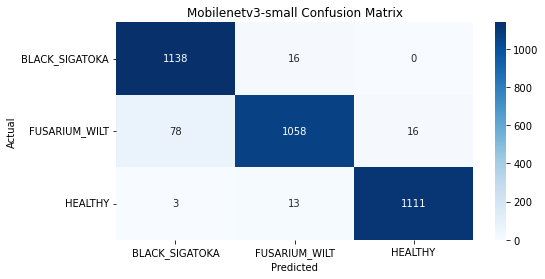

In [19]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Create a heatmap with seaborn
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Mobilenetv3-small Confusion Matrix')
plt.show()

#Plotting the graphs

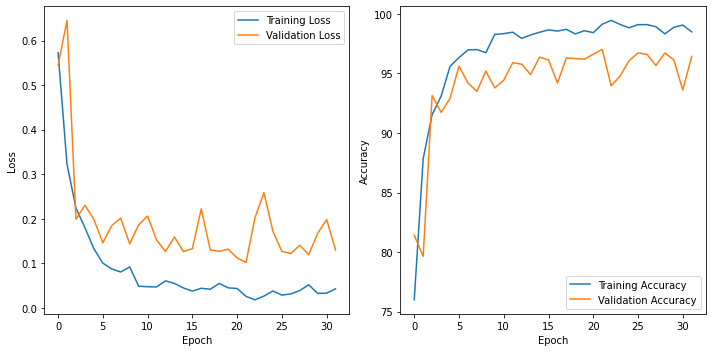

In [20]:
# Plot loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

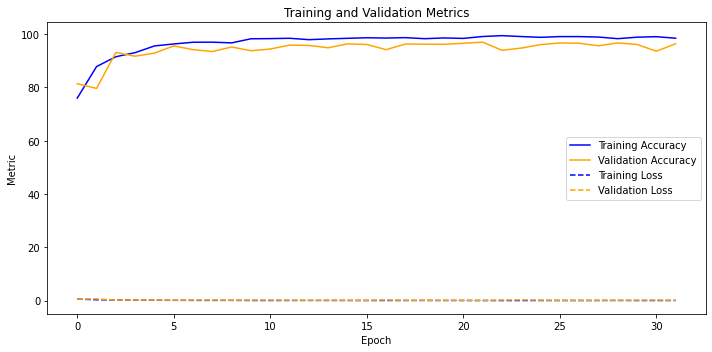

In [21]:
# Plot loss and accuracy graphs on a single set of axes
plt.figure(figsize=(10, 5))

# Plot Accuracy
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(valid_accuracy, label='Validation Accuracy', color='orange')

# Plot Loss
plt.plot(train_losses, label='Training Loss', linestyle='--', color='blue')
plt.plot(valid_losses, label='Validation Loss', linestyle='--', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Training and Validation Metrics')

plt.tight_layout()
plt.show()

#Optimization results analysis

<ipython-input-26-4b56def4d7d0>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);


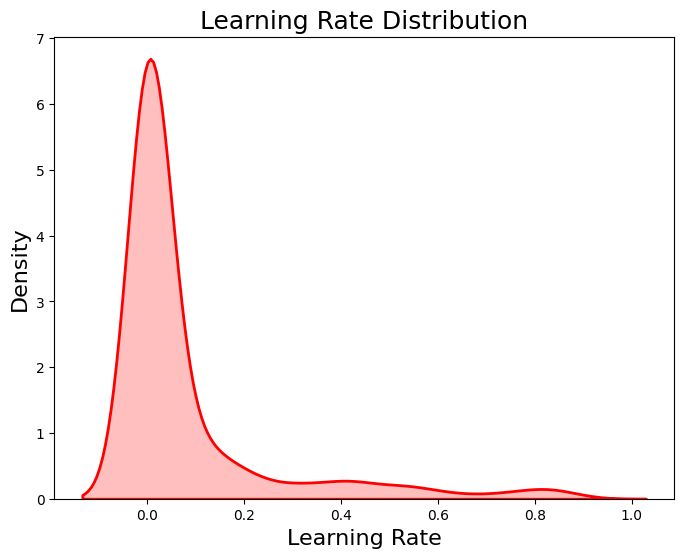

In [ ]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.9))}
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(1000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])

plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18);
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

<ipython-input-27-9d5769e05dea>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(momentum_dist, color = 'blue', linewidth = 2, shade = True);


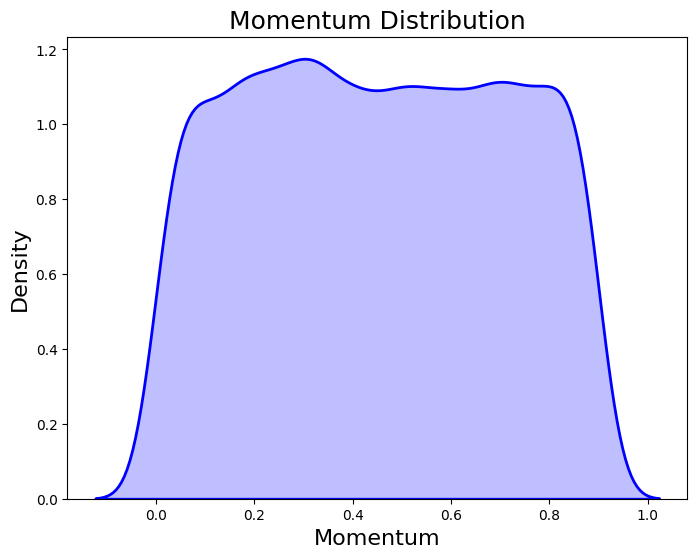

In [ ]:
momentum = {'momentum': hp.uniform('momentum', 0.0, 0.9)}
momentum_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    momentum_dist.append(sample(momentum)['momentum'])

plt.figure(figsize = (8, 6))
sns.kdeplot(momentum_dist, color = 'blue', linewidth = 2, shade = True);
plt.title('Momentum Distribution', size = 18);
plt.xlabel('Momentum', size = 16); plt.ylabel('Density', size = 16);

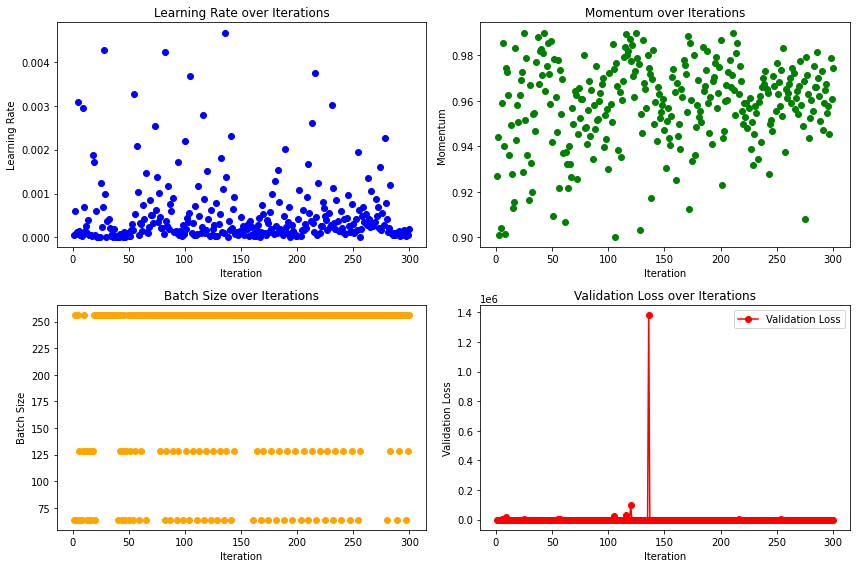

In [22]:
import ast
# Load the optimization results from the CSV file
results_df = pd.read_csv('/home/g6501222802/thesis/results/mobilenetv3-small-cbam_s2_results.csv')

# Convert the 'params' column from string to dictionary
results_df['params'] = results_df['params'].apply(ast.literal_eval)

iterations = np.array(results_df['iterations'])
loss = np.array(results_df['loss'])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Scatter plot for learning rate
axs[0, 0].scatter(iterations, results_df['params'].apply(lambda x: x['learning_rate']),  color='blue', marker='o', label='Learning Rate')

# Scatter plot for momentum
axs[0, 1].scatter(iterations, results_df['params'].apply(lambda x: x['momentum']),  color='green', marker='o', label='Momentum')

# Scatter plot for batch size
axs[1, 0].scatter(iterations, results_df['params'].apply(lambda x: x['batch_size']),  color='orange', marker='o', label='Batch Size')

# Line chart for objective values (e.g., validation loss) over iterations
axs[1, 1].plot(iterations, loss,  color='red', marker='o', label='Validation Loss')

# Set titles and labels for all subplots
axs[0, 0].set_title('Learning Rate over Iterations')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Learning Rate')

axs[0, 1].set_title('Momentum over Iterations')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Momentum')

axs[1, 0].set_title('Batch Size over Iterations')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Batch Size')

axs[1, 1].set_title('Validation Loss over Iterations')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Validation Loss')

# Display a combined legend for all subplots
plt.legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

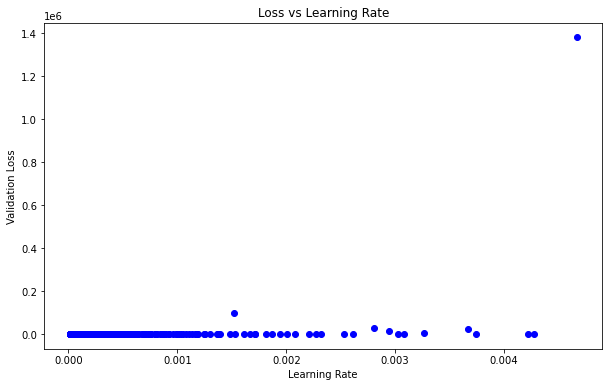

In [23]:
# Load the optimization results from the CSV file
results_df = pd.read_csv('/home/g6501222802/thesis/results/mobilenetv3-small-cbam_s2_results.csv')

# Convert the 'params' column from string to dictionary
results_df['params'] = results_df['params'].apply(ast.literal_eval)

fig, ax1 = plt.subplots(figsize=(10, 6))
# Create a scatter plot for loss against learning_rate
plt.scatter(results_df['params'].apply(lambda x: x['learning_rate']), results_df['loss'], color='blue', marker='o')
plt.title('Loss vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')

# Show the plot
plt.show()

Model Comlexity Analysis

In [27]:
#COunting the number of parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = models.mobilenet_v3_small(pretrained=True)  # Pre-trained Mobilenetv3-smal

total_params, trainable_params = count_parameters(model)
print(f'Total Parameters: {total_params}')
print(f'Trainable Parameters: {trainable_params}')

Total Parameters: 2542856
Trainable Parameters: 2542856


/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
#Model Size Check
def model_size_in_memory(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    size_in_mb = param_size / (1024 ** 2)  # Convert to megabytes
    return size_in_mb

size_in_mb = model_size_in_memory(model)
print(f'Approximate Model Size in Memory: {size_in_mb:.2f} MB')

Approximate Model Size in Memory: 9.70 MB
